# Task 3: Helper notebook for loading the data and saving the predictions

In [1]:
import pickle
import gzip
import numpy as np
import os

import matplotlib.pyplot as plt
import cv2
import cv2 as cv
from tensorflow.keras.preprocessing.image import load_img

### Helper functions

In [2]:
def load_zipped_pickle(filename):
    with gzip.open(filename, 'rb') as f:
        loaded_object = pickle.load(f)
        return loaded_object

In [3]:
def save_zipped_pickle(obj, filename):
    with gzip.open(filename, 'wb') as f:
        pickle.dump(obj, f, 2)

In [4]:
def evaluate(predictions, targets):
    ious = []
    for p, t in zip(predictions, targets):
        assert p['name'] == t['name']
        prediction = np.array(p['prediction'], dtype=bool)
        target = np.array(t['label'], dtype=bool)

        assert target.shape == prediction.shape
        overlap = prediction*target
        union = prediction + target

        ious.append(overlap.sum()/float(union.sum()))
    
    print("Median IOU: ", np.median(ious))

### Load data, make predictions and save prediction in correct format

In [5]:
# load data
train_data = load_zipped_pickle("train_enhanced.pkl")
test_data = load_zipped_pickle("test.pkl")
samples = load_zipped_pickle("sample.pkl")

FileNotFoundError: [Errno 2] No such file or directory: 'train_enhanced.pkl'

In [7]:
# make prediction for test
predictions = []
for d in test_data:
    prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)
    height = prediction.shape[0]
    width = prediction.shape[1]
    prediction[int(height/2)-50:int(height/2+50), int(width/2)-50:int(width/2+50)] = True
    
    # DATA Strucure
    predictions.append({
        'name': d['name'],
        'prediction': prediction
        }
    )

C:\Users\hmirf\AppData\Local\Temp/ipykernel_9340/701677749.py:4: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  prediction = np.array(np.zeros_like(d['video']), dtype=np.bool)


In [ ]:
# save in correct format
save_zipped_pickle(predictions, 'my_predictions.pkl')

## Showing the animation inline:
solution taken from https://stackoverflow.com/questions/43445103/inline-animations-in-jupyter

also see http://louistiao.me/posts/notebooks/embedding-matplotlib-animations-in-jupyter-notebooks/

In [6]:

from matplotlib import animation
from IPython.display import HTML

#%matplotlib inline

def play_video(img_list):
  def init():
    img.set_data(img_list[0])
    return (img,)

  def animate(i):
    img.set_data(img_list[i])
    return (img,)

  fig = plt.figure()
  ax = fig.gca()
  img = ax.imshow(img_list[0], cmap='gray', vmin=0, vmax=255)
  anim = animation.FuncAnimation(fig, animate, init_func=init,
                                 frames=len(img_list), interval=20, blit=True)
  return anim




0
116
117
115
101
110
96
104
96
118
84
97
92
94
70
78
88
82
76
72
84
105
131
135
125
126
121
131
0
0
151
165
174
163
160
159
164
166
179
179
170
172
150
119
116
97
121
151
107
115
116
0
0
120
114
105
93
145
94
100
0
Showing the training sample 57:


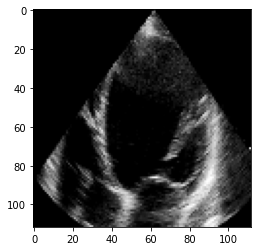

In [29]:
train_sample_id = 57
crop = False

video = np.copy(train_data[train_sample_id]['video'])
labels = train_data[train_sample_id]['label']
box = train_data[train_sample_id]['box']
labeled_frames = train_data[train_sample_id]['frames']


# first overlay the box and the labels of mitral valve wherever available
alpha = 0.2  # alpha blending parameter to overlay the box

video_sml = np.zeros((112,112,video.shape[2]))
labels_sml = np.zeros((112,112,video.shape[2]))

for i in range(video.shape[2]):
    frame = video[:,:,i]
    frame = cv2.resize(frame, dsize=(112, 112), interpolation=cv2.INTER_CUBIC)
    lbl = (labels[:,:,i]*255).astype(np.uint8)
    labels_sml[:,:,i] = cv2.resize(lbl, dsize=(112, 112), interpolation=cv2.INTER_CUBIC)
    # add the labels
    frame[(labels_sml[:,:,i] > 0)] = 255
    print(np.count_nonzero((labels_sml[:,:,i] > 0)))
    video_sml[:,:,i] = frame
# for i in range(video.shape[2]):
#     # overlay the box on all images
#     video[:,:,i] = (1-alpha)*video[:,:,i] + alpha*255*box
    
print("Showing the training sample " + str(train_sample_id) + ":")

if crop:
    boxnz = np.nonzero(box)
    w = boxnz[1][-1] - boxnz[1][0]
    y0 = boxnz[0][-1]-w
    y1 = boxnz[0][-1]
    x0 = boxnz[1][0]
    x1 = boxnz[1][-1]
else:
    y0 = 0
    y1 = video.shape[0]
    x0 = 0
    x1 = video.shape[1]

imgs = [video_sml[y0:y1,x0:x1,i] for i in range(video.shape[2])]


HTML(play_video(imgs).to_jshtml())

In [63]:

# THR = 80

# num_train_samples = 0
# for train_sample_id in range(65):
#     video = np.copy(train_data[train_sample_id]['video'])
#     labels = train_data[train_sample_id]['label']
#     for i in range(video.shape[2]):
#         #frame = video[:,:,i]
#         #frame = cv2.resize(frame, dsize=(112, 112), interpolation=cv2.INTER_CUBIC)
#         lbl = (labels[:,:,i]*255).astype(np.uint8)
#         lbl_sml = cv2.resize(lbl, dsize=(112, 112), interpolation=cv2.INTER_CUBIC)

#         if np.count_nonzero((lbl_sml > 0)) > THR:
#             num_train_samples += 1


video_sml = np.zeros((num_train_samples+1, 112,112))
labels_sml = np.zeros((num_train_samples+1, 112,112))

train_idx = 0
for train_sample_id in range(65):
    video = np.copy(train_data[train_sample_id]['video'])
    labels = train_data[train_sample_id]['label']
    for i in range(video.shape[2]):
        frame = video[:,:,i]
        frame = cv2.resize(frame, dsize=(112, 112), interpolation=cv2.INTER_CUBIC)
        lbl = (labels[:,:,i]*255).astype(np.uint8)
        lbl_sml = cv2.resize(lbl, dsize=(112, 112), interpolation=cv2.INTER_CUBIC)
        if np.count_nonzero((lbl_sml > 0)) > THR:
            train_idx += 1
            labels_sml[train_idx,:,:] = (lbl_sml > 0)
            video_sml[train_idx,:,:] = frame
        else:
            continue

# TRACK LEAFLETS VERSION 2

In [452]:
from skimage.segmentation import morphological_chan_vese
from skimage.filters import gaussian
from skimage.segmentation import active_contour
from skimage.filters import difference_of_gaussians
from skimage.morphology import convex_hull_image
from skimage import measure

DO_THRESHOLD = False
threshold_scale = 0.7
N_ITER = 20
offset = 1

def track_leaflets(image, cont_old, blob_old, i):
    if DO_THRESHOLD:
        mean_MV_intensity = np.mean(image[(blob_old > 0)])
        image[image < threshold_scale*mean_MV_intensity] = 0
    
    blob_new = morphological_chan_vese(gaussian(image, 1, preserve_range=False), 
                                 iterations=N_ITER, init_level_set=blob_old, smoothing=0)
    
    snake_list = []
    if len(cont_old) < 1:
        print("zero contour")
    for cc in cont_old:
        if cc.size > 0:
            snake = active_contour(difference_of_gaussians(image, 1, 100),
                               cc, alpha=0.2, beta=20, gamma=0.001, w_edge = 100)

            snake = np.rint(snake)
            snake = snake.astype(int)
            snake = snake[(snake[:,0] > 0) & (snake[:,1] > 0) & (snake[:,0] < image.shape[0]) & (snake[:,1] < image.shape[1])]
            snake_list.append(snake)
    
    cont_old_size = 0
    for cc in cont_old:
        cont_old_size = cont_old_size + cc.size
        
    snake_size = 0
    for cc in snake_list:
        snake_size = snake_size + cc.size
        
        
    if snake_size > 10:
        snake = np.concatenate((snake_list))
        blank = np.zeros(image.shape)
        blank[snake[:,0], snake[:,1]] = 255
        chull = convex_hull_image(blank)
        if np.count_nonzero(chull) == 0:
            print("snake_size: " + str(snake_size)  + " - chull size: " + str(snake.size))
    else:
        snake_list = cont_old
        snake = np.concatenate((snake_list))
        blank = np.zeros(image.shape)
        blank[snake[:,0], snake[:,1]] = 255
        chull = convex_hull_image(blank)
        if np.count_nonzero(chull) == 0:
            print("cont_old_size: " + str(cont_old_size) + " - chull size: " + str(snake.size))
    
    
    blob_new[~chull] = 0
    return snake_list, blob_new



for train_sample_id in range(0,13):
    crop = True

    video = np.copy(train_data[train_sample_id]['video'])
    labels = train_data[train_sample_id]['label']
    box = train_data[train_sample_id]['box']
    labeled_frames = train_data[train_sample_id]['frames']

    alpha = 0.2  # alpha blending parameter to overlay the box

    for i in range(video.shape[2]):
        frame = video[:,:,i]
        # add the labels
        frame[labels[:,:,i]] = 255

    print("Showing the training sample " + str(train_sample_id) + ":")

    if crop:
        boxnz = np.nonzero(box)
        w = boxnz[1][-1] - boxnz[1][0]
        y0 = boxnz[0][-1]-w
        y1 = boxnz[0][-1]
        x0 = boxnz[1][0]
        x1 = boxnz[1][-1]
    else:
        y0 = 0
        y1 = video.shape[0]
        x0 = 0
        x1 = video.shape[1]

    imgs = [video[y0:y1,x0:x1,i] for i in range(video.shape[2])]


    imgs_cp = np.copy(imgs)



    # ----------------- track contour of labeled frame 0 -----------------
    lf = labeled_frames[0]
    frame_range = range(0, (labeled_frames[0] + labeled_frames[1])//2)

    labeled_cont = measure.find_contours(labels[y0:y1,x0:x1,lf]*255)
    init_contours = [np.squeeze(np.asarray(ll, dtype=int)) for ll in labeled_cont]

    snakes = init_contours
    blobb = np.copy(labels[y0:y1,x0:x1,lf])
    for i in range(lf - offset, frame_range[0], -1):
        snakes, blobb = track_leaflets(imgs_cp[i], snakes, blobb, i)
        if i != lf:
            labels[y0:y1,x0:x1,i] = (blobb > 0)
            imgs_cp[i][labels[y0:y1,x0:x1,i]] = 255

    snakes = init_contours
    blobb = np.copy(labels[y0:y1,x0:x1,lf])
    for i in range(lf + offset, frame_range[-1]):
        snakes, blobb = track_leaflets(imgs_cp[i], snakes, blobb, i)
        if i != lf:
            labels[y0:y1,x0:x1,i] = (blobb > 0)
            imgs_cp[i][labels[y0:y1,x0:x1,i]] = 255

    # ----------------- track contour of labeled frame 1 -----------------
    lf = labeled_frames[1]
    frame_range = range((labeled_frames[0] + labeled_frames[1])//2, (labeled_frames[1] + labeled_frames[2])//2)

    labeled_cont = measure.find_contours(labels[y0:y1,x0:x1,lf]*255)
    init_contours = [np.squeeze(np.asarray(ll, dtype=int)) for ll in labeled_cont]

    snakes = init_contours
    blobb = np.copy(labels[y0:y1,x0:x1,lf])
    for i in range(lf - offset, frame_range[0], -1):
        snakes, blobb = track_leaflets(imgs_cp[i], snakes, blobb, i)
        if i != lf:
            labels[y0:y1,x0:x1,i] = (blobb > 0)
            imgs_cp[i][labels[y0:y1,x0:x1,i]] = 255

    snakes = init_contours
    blobb = np.copy(labels[y0:y1,x0:x1,lf])
    for i in range(lf + offset, frame_range[-1]):
        snakes, blobb = track_leaflets(imgs_cp[i], snakes, blobb, i)
        if i != lf:
            labels[y0:y1,x0:x1,i] = (blobb > 0)
            imgs_cp[i][labels[y0:y1,x0:x1,i]] = 255
    # ----------------- track contour of labeled frame 2 -----------------
    lf = labeled_frames[2]
    frame_range = range((labeled_frames[1] + labeled_frames[2])//2, imgs_cp.shape[0])

    labeled_cont = measure.find_contours(labels[y0:y1,x0:x1,lf]*255)
    init_contours = [np.squeeze(np.asarray(ll, dtype=int)) for ll in labeled_cont]

    snakes = init_contours
    blobb = np.copy(labels[y0:y1,x0:x1,lf])
    for i in range(lf - offset, frame_range[0], -1):
        snakes, blobb = track_leaflets(imgs_cp[i], snakes, blobb, i)
        if i != lf:
            labels[y0:y1,x0:x1,i] = (blobb > 0)
            imgs_cp[i][labels[y0:y1,x0:x1,i]] = 255

    snakes = init_contours
    blobb = np.copy(labels[y0:y1,x0:x1,lf])
    for i in range(lf + offset, frame_range[-1]):
        snakes, blobb = track_leaflets(imgs_cp[i], snakes, blobb, i)
        if i != lf:
            labels[y0:y1,x0:x1,i] = (blobb > 0)
            imgs_cp[i][labels[y0:y1,x0:x1,i]] = 255

    train_data[train_sample_id]['label'] = labels
    #HTML(play_video(imgs_cp).to_jshtml())

Showing the training sample 0:
Showing the training sample 1:
Showing the training sample 2:
Showing the training sample 3:
Showing the training sample 4:
Showing the training sample 5:
Showing the training sample 6:
Showing the training sample 7:
Showing the training sample 8:
Showing the training sample 9:
Showing the training sample 10:
Showing the training sample 11:
Showing the training sample 12:


In [61]:
np.std(video_sml)

58.88277722279382

In [82]:

from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras import backend as K

from keras.callbacks import TensorBoard
tb_callback = TensorBoard(log_dir='./logs', histogram_freq=1, batch_size=32, write_graph=True, write_grads=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None)

from data import load_train_data, load_test_data

from vis.visualization import visualize_activation, visualize_saliency, visualize_cam, overlay as vis_overlay
from vis.utils import utils
import matplotlib.pyplot as plt


K.set_image_data_format('channels_last')  # TF dimension ordering in this code

img_rows = 112
img_cols = 112

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def get_unet():
    inputs = Input((img_rows, img_cols, 1))
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv6)

    up7 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid', name='dense')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    model.compile(optimizer=Adam(lr=1e-3), loss=dice_coef_loss, metrics=[dice_coef])

    return model






print('*'*30)
print('Loading and preprocessing train data...')
print('*'*30)


imgs_train = video_sml
imgs_mask_train = labels_sml


imgs_train = imgs_train.astype('float32') # TODO: eval float32
imgs_mask_train = imgs_mask_train.astype('float32')
mean = np.mean(imgs_train)  # mean for data centering
std = np.std(imgs_train)  # std for data normalization

imgs_train -= mean
imgs_train /= std


print('*'*30)
print("Max mask value:" + str(np.amax(imgs_mask_train)))
print("Min mask value:" + str(np.amin(imgs_mask_train)))

print('*'*30)
print('Creating and compiling model...')
print('*'*30)
model = get_unet()
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

print('*'*30)
print('Fitting model...')
print('*'*30)
model.fit(imgs_train, imgs_mask_train, batch_size=4, epochs=30, verbose=1, shuffle=True, # was True
          validation_split=0.2,
          callbacks=[model_checkpoint, tb_callback])

print('*'*30)
print('Loading and preprocessing test data...')
print('*'*30)
imgs_test, imgs_id_test, imgs_header_test = load_test_data()
imgs_test = preprocess(imgs_test)

imgs_test = imgs_test.astype('float32')
imgs_test -= mean
imgs_test /= std

print('*'*30)
print('Loading saved weights...')
print('*'*30)
model.load_weights('weights.h5')

print('*'*30)
print('Predicting masks on test data...')
print('*'*30)
imgs_mask_test = model.predict(imgs_test, verbose=1)
np.save('imgs_mask_test.npy', imgs_mask_test)

print('-' * 30)
print('Saving predicted masks to files...')
print('-' * 30)




ModuleNotFoundError: No module named 'keras.models'